In [282]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from ast import literal_eval
import matplotlib.pyplot as plt

# functions for pipeline

In [283]:
def drop_categories(df):
    # this function drops all categories of API output which are irrelevant for prediction
    
    # possibly also drop controller_support, fullgame columns
    df.drop("dlc",axis=1, inplace=True)
    df.drop("review_score_desc",axis=1, inplace=True)
    df.drop("legal_notice",axis=1, inplace=True)
    df.drop("recommendations",axis=1, inplace=True)
    df.drop("ext_user_account_notice",axis=1, inplace=True)
    df.drop("reviews",axis=1, inplace=True)
    df.drop("metacritic",axis=1, inplace=True)
    df.drop("demos",axis=1, inplace=True)
    df.drop("drm_notice",axis=1, inplace=True)
    df.drop("alternate_appid",axis=1, inplace=True)
    df.drop("screenshots",axis=1, inplace=True)
    df.drop("movies",axis=1, inplace=True)
    df.drop("support_info",axis=1, inplace=True)
    df.drop("background",axis=1, inplace=True)
    df.drop("background_raw",axis=1, inplace=True)
    df.drop("content_descriptors",axis=1, inplace=True)
    df.drop("packages",axis=1, inplace=True)
    df.drop("package_groups",axis=1, inplace=True)
    df.drop("num_reviews",axis=1, inplace=True)
    df.drop("developers",axis=1, inplace=True)
    df.drop("achievements",axis=1, inplace=True)
    df.drop("detailed_description",axis=1, inplace=True)
    df.drop("about_the_game",axis=1, inplace=True)
    df.drop("supported_languages",axis=1, inplace=True)
    df.drop("header_image",axis=1, inplace=True)
    df.drop("website",axis=1, inplace=True)


In [284]:
def drop_few_review_games(df, num_reviews=50):
    # drop games with less than num_reviews reviews. also reset the index after dropping rows
    df =  df.loc[lambda df: df['total_reviews'] >= num_reviews, :].reset_index(drop=True)
    return df

In [285]:
def clean_price(df):
    # Clean up "price_overview" output of API and add new column "price"
    # use price without discounts(initial)
    
    df["price"] = 0
    
    # iterate through rows
    for index, row in df.iterrows():
        
        # if free to play, keep 0
        if not row.is_free:
            
            # try to read the entry as a dictionary
            try:
                dict = literal_eval(str(row.price_overview).replace("''",'None'))
            
            # if not possible delete row
            except: 
                df.drop(index, inplace=True)
            
            # if possible
            else: 
                
                # if currency is not EUR
                if dict["currency"] != "EUR":
                    
                    # delete row
                    df.drop(index, inplace=True)
            
                # get price
                else:
                    df["price"].loc[index] = dict["initial"]
                    
    df = df.drop('price_overview', axis=1).reset_index(drop=True)
    
    return df


In [286]:
def drop_high_price_games(df, max_price=200):
    # drops few outlier games which have unreasonably high prices. max price is price in euros (price/100)
    df=  df.loc[lambda df: df['price']/100 <= max_price, :].reset_index(drop=True)
    return df

In [287]:
def clean_genres(df):
    # this function takes the API output of the column genres and cleans it up
    #genres are shown in a list in new column "genres_clean" in output dataframe
    
    df["genres_clean"] = ""
    
    # iterate through rows
    for index, row in df.iterrows():
            
        # try to read the entry as a dictionary
        try:
            dict = literal_eval(str(row.genres).replace("''",'None'))
        
        # if not possible delete row
        except: 
            df.drop(index, inplace=True)
        
        # if possible
        else:
             
            genres = []
            
            for j in range(len(dict)):
                genres.append(dict[j]["description"])
            
            df["genres_clean"].loc[index] = np.array(genres)
                    
    df.drop('genres', axis=1, inplace=True)

    return df

In [288]:
def get_genres_set(df):
    # this function iterates through the new column "genres_clean" and return the set of unique genres contained in the dataframe
    G = []
    
    for idx,row in df.iterrows():
        
        for j in range(len(row.genres_clean)):
            G.append(row.genres_clean[j])
    
    return list(set(G))
        

In [289]:
def one_hot_encode_genres(df,G):
    # this function creates a new column for each unique genre in the dataframe to one-hot-encode it.
    for j in G:
        df[j] = 0
    
    for idx,row in df.iterrows():
        for genre in row.genres_clean:
            df[genre].loc[idx] = 1
    return df

# test pipeline

In [290]:
df = pd.read_csv("raw_data.csv", index_col=0, low_memory=False)

In [291]:
# clean and pre-process data
drop_categories(df)
df = drop_few_review_games(df, num_reviews=50)
df = clean_price(df)
df = drop_high_price_games(df, max_price=200)
df = clean_genres(df)
G = get_genres_set(df)
df = one_hot_encode_genres(df,G)

/Users/emilbreustedt/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/emilbreustedt/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [292]:
df.to_csv('clean_data.csv')
df

,appid,name,review_score,total_positive,total_negative,total_reviews,type,required_age,is_free,short_description,...,Video Production,Casual,Sexual Content,Photo Editing,Action,Design & Illustration,Audio Production,Nudity,Utilities,Software Training
0,1648390,ScooterFlow,8,446,21,467,game,0,False,The world’s most realistic freestyle scooter g...,...,0,1,0,0,0,0,0,0,0,0
1,1648610,Malum,6,146,53,199,game,0,False,Malum is the premier C-list horror game. Run f...,...,0,0,0,0,1,0,0,0,0,0
2,1647962,Hell Let Loose – Lethal Tide,8,70,6,76,dlc,0,False,Unlock access to the Lethal Tide DLC.,...,0,0,0,0,1,0,0,0,0,0
3,1647550,NEO: The World Ends with You,8,224,11,235,game,0,False,&quot;Only the possibility of you can change o...,...,0,0,0,0,1,0,0,0,0,0
4,1647730,Zool Redimensioned,8,68,2,70,game,0,False,The Ninja of the Nth Dimension is back! Explor...,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3219,1490117,Train Sim World 2: Rush Hour - Boston Sprinter,5,45,24,69,dlc,0,False,"Experience the fastest rail line in America, f...",...,0,0,0,0,0,0,0,0,0,0
3220,540340,Resident Evil 7 - Season Pass,5,80,48,128,dlc,18,False,Purchase the Resident Evil 7 biohazard Season ...,...,0,0,0,0,1,0,0,0,0,0
3221,209670,Cortex Command,8,984,242,1226,game,0,False,"Choose between different factions, with their ...",...,0,0,0,0,1,0,0,0,0,0
3222,933060,Hentai Weed PuZZles,6,38,12,50,game,0,False,This is a jigsaw puzzle game in which you need...,...,0,1,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Score distribution')

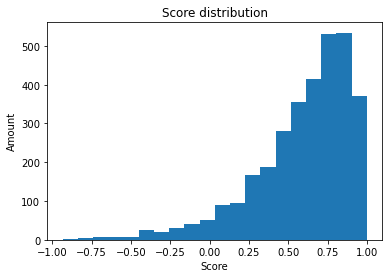

In [293]:
# calculate score
score = (df.total_positive - df.total_negative)/df.total_reviews

# plot distribution
plt.hist(score, bins=20)
plt.xlabel("Score")
plt.ylabel("Amount")
plt.title("Score distribution")
